# Acknowledgement
This code has been implemented following the IEEE Access paper: **"Facial Expression Recognition Using Multi-Branch Attention Convolutional Neural Network"**

**Link: https://ieeexplore.ieee.org/document/10004585#:~:text=This%20paper%20develops%20a%20multi,from%20three%20branches%20are%20fused.**

# Importing Libraries

All the required libraries are imported here

In [1]:
#Standard libraries for dataframe building, manipulation and data visualization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob # for file manipulation for datafram building
import matplotlib.pyplot as plt # for image plotting
import cv2 # for image processing and showing
import os

#Tensorflow and Keras for Deep Learning Model building
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, DepthwiseConv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.layers import Concatenate, BatchNormalization, Activation
from keras.layers import multiply, Add, Reshape
from keras.layers import GlobalMaxPooling2D, Permute, Lambda
from keras import ops as Kops
from keras import backend as Kend
from keras.activations import sigmoid

from keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        TensorBoard)
from tensorflow.keras.optimizers import Adam

#for Data augmentation
import albumentations as A

#for model visualization
from tensorflow.keras.utils import plot_model

# For Accuracy metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

2024-03-01 16:36:46.973758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 16:36:46.973882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 16:36:47.115220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Parameters

In [2]:
reduction_ratio = 8            #default value is 8
EPOCHS = 300                   #original 300 with no early stopping
BATCH_SIZE = 64                #original 64
VALID_BATCH_SIZE = 2           #original not known
LEARNING_RATE = 1e-03          #original 0.001
EARLY_STOPPING_PATIENCE = 10   #original paper had no early stopping
DROPOUT = 0.2                  #Dropout percentage for all dropout layers

# Model Architecture
(All images here are taken from the mother paper, SENet paper and CBAM paper, all of these with their full titles and links are given)

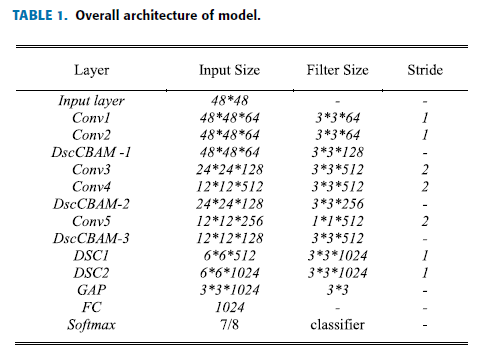

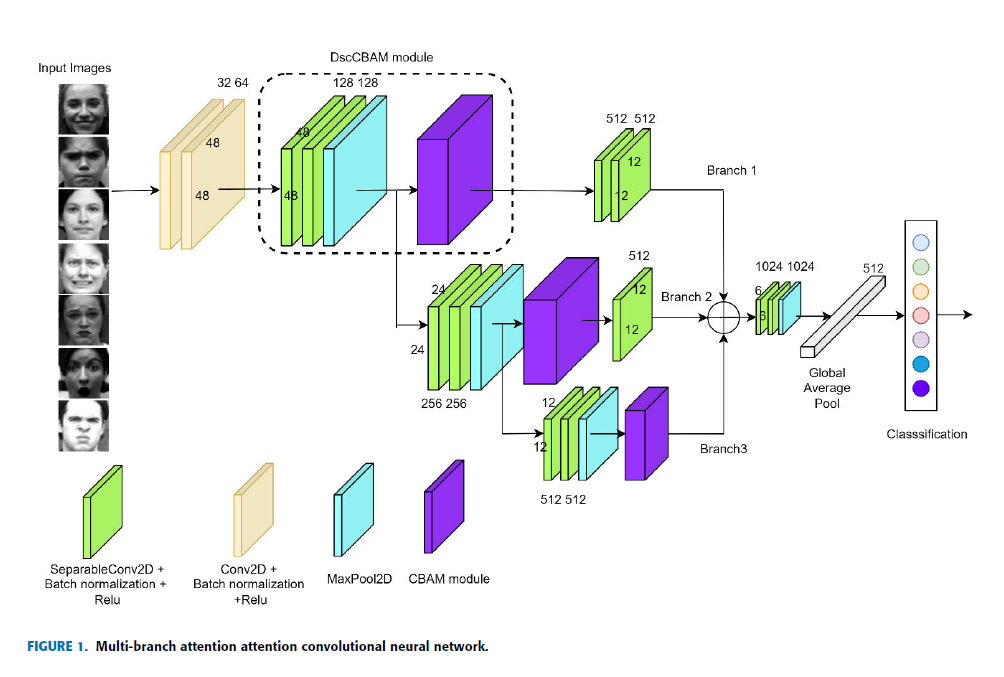

The figure above shows the whole model as shown in the mother paper. The model develops a multi-branch attention CNN for facial expression recognition, which combines **the Convolutional Block Attention Module, Depthwise separable convolution, and a three branch structure**. The Convolutional Block Attention module was exploited to enable a **better extracting of features** from facial expression images, and depthwise separable convolution was added to **reduce the model parameters**. The novelty of this paper lies in its use of a module called DSC-CBAM that combines Depthwise Separable Convolution with a Convolutional Block Attention Module to assist the model in **giving priority to features as well as spatial regions that require more focus** while classification tasks.

# The Model

## Convolutional Block Attention Module Implementation

The **Convolutional Block Attention Module (CBAM)** is an improvement over the standard **Squeeze and Excitation Net (SENet)**. Squeeze-and-Excitation Networks (SENet) are a type of neural network architecture designed to enhance feature recalibration and channel interdependencies. Introduced by Jie Hu et al. in 2017, SENets introduce two key operations: **"squeeze"** and **"excitation."** 

The "squeeze" operation compresses spatial information into channel-wise descriptors through **global average pooling**, reducing computational complexity. The "excitation" operation learns to emphasize informative features and suppress less relevant ones by adaptively recalibrating feature responses using learned weights. It does this by multiplying the features with the learned weights. Augmenting CNN models like ResNet, VGG etc with a SE Module significantly improves model performance. The following figure shows a visualization of the SENet structure augmented to a CNN model:
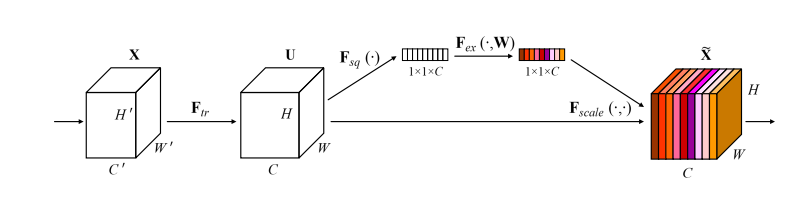!

The link to the paper **"Squeeze-and-Excitation Networks"** is as follows:

**https://arxiv.org/pdf/1709.01507.pdf**

The **Convolutional Block Attention Module (CBAM)** improves over the standard **Squeeze and Excitation Net (SENet)** by adding a spatial attention mechanism along with the Channel Attention Mechanism developed in SENet. But it does this in a manner different from the SENet approach. The link to the paper **CBAM: Convolutional Block Attention Module** is as follows:
**https://arxiv.org/abs/1807.06521**

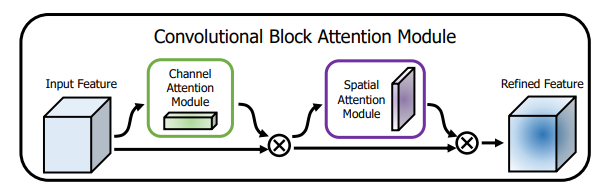

The CBAM block has two modules sequentially: The **Channel Attention Module** and the **Spatial Attention Module**
The Channel Attention Module is followed by the Spatial Attention layer. 


In the **Channel Attention Module (CAM)**, the input feature tensor F $\epsilon$   $\mathbb{R}^{C x H x W}$, is taken and Global Max Pooling and Global Average Pooling are performed on it separately along the channel axis to obtain two output tensors having dimension C. Then these two feature tensors are passed through a shared MLP, which has three layers including input and output layer. Thus there are two separate weight vectors connecting them that act on these. 
Mathematically,


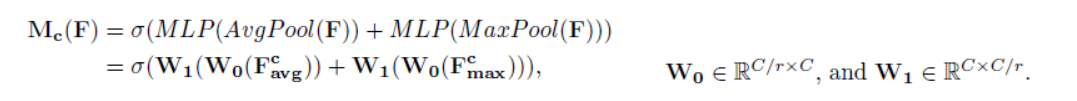

Here, $\sigma$ denotes the sigmoid activation function. The MLP is shared for both inputs and the ReLU activation function is followed by the first input layer. An important thing to notice here is the reduction ratio, r, a positive integer. The hidden layer can reduce the number of neurons by r and the again increase to original number in the output layer. This reduces computational cost for r > 1.

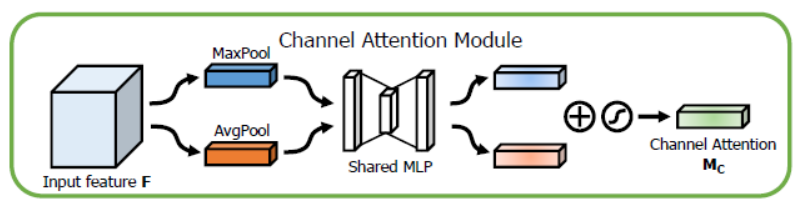


After passing through MLP, two sets of weights having length equal to number of channels in input feature tensor are found. These are added elementwise and passed through a sigmoid activation function to generate the final set of Channel Attention Module weights $M_{c}$   $\epsilon$   $\mathbb{R}^{C}$. These weights will be multiplied to corresponding channels of the input feature tensor to obtain the channel refined feature tensor F'.


In [3]:
def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if Kend.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if Kend.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

In the **Spatial Attention Module (SAM)**, the channel refined feature tensor undergoes MaxPooling and Average Pooling separately, but this time along the height and width axis, thus collapsing the channel axis. Two output tensors are obtained each having size 1 x H x W. The output is of size 2 x H x W. A 7 x 7 convolution acts on this to obtain a 1 x H x W sized output that is then passed through a sigmoid function to obtain the final spatial weight tensor $M_{s}$ $\epsilon$   $\mathbb{R}^{H x W}$. Mathematically,

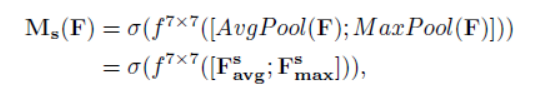

After multiplying the spatial attention weight to each channel of the channel refined feature tensor F', the final output is obtained, which is the channel-refined and spatially refined feature tensor. 

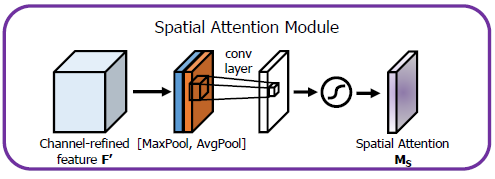

In [4]:
def spatial_attention(input_feature):
	kernel_size = 7
	
	if Kend.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: Kops.mean(x, axis=3, keepdims=True), output_shape=(None, None, 1))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: Kops.max(x, axis=3, keepdims=True), output_shape=(None, None, 1))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if Kend.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

Sequentially going through the Channel Attention Module and Spatial Attention Module produces the output of the Convolutional Block Attention Module

In [5]:
def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

This concludes the creation of the CBAM. The code for CBAM was taken from: **https://github.com/kobiso/CBAM-tensorflow**

## Model Implementation

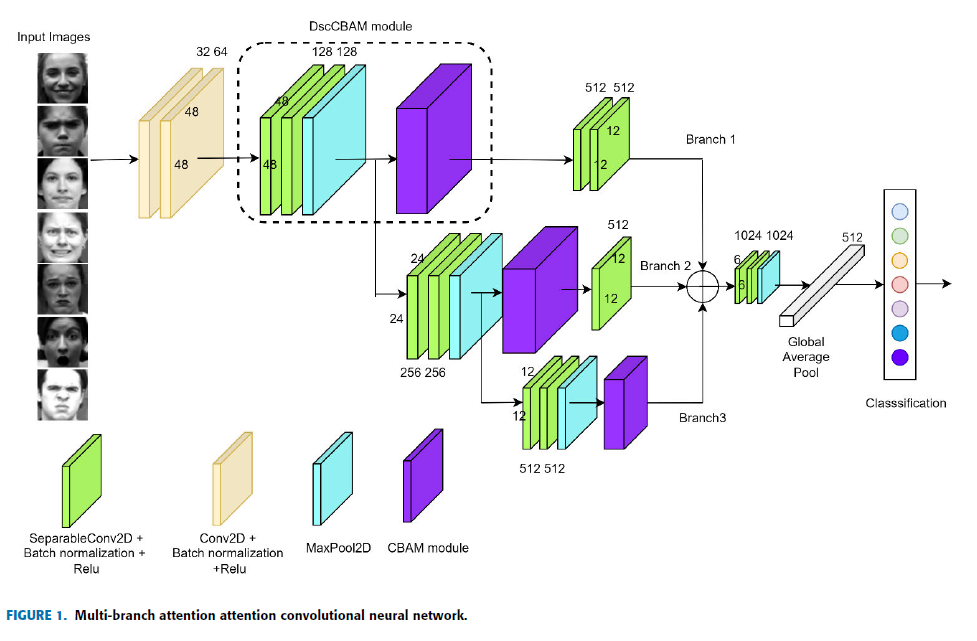

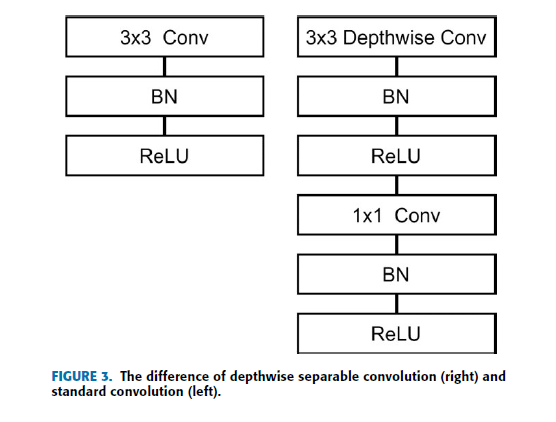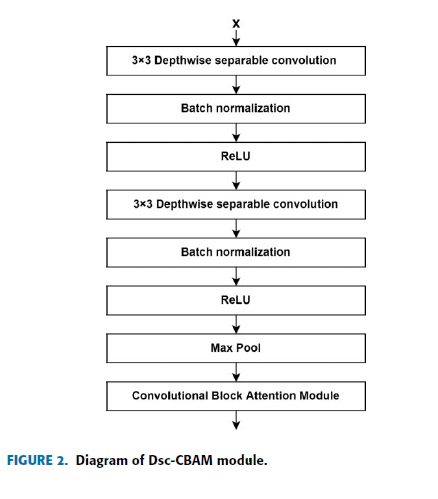


### Inconsistencies in the paper
The model architecture shows some **inconsistency** across the paper. The **first** inconsistency lies in the number of filter in the first convolutional layer. While the **diagram of the model shows 32**, the **overall architecture summary shows 64**. 32 was taken as filter size in the code. 

Secondly, the **Batch Normalization** and **ReLU** layers are **already incorporated** in the Depthwise Separable Convolution **(DSC)** layer, but the **DSC-CBAM repeats them**. They were not repeated in this code.

Thirdly, dropout is said to be included in the model, but it is **not specified exactly where dropouts** are implemented.

In [6]:
def build_model():
    # Input layer
    input_layer = Input(shape=(48, 48, 1))



    #Initial Convolution Layers

    # Conv1 layer

    #Convolution
    conv1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(input_layer)
    #Batch Normalization
    norm1 = BatchNormalization()(conv1)
    #Activation
    act1 = Activation('relu')(norm1)


    # Conv2 layer

    #Convolution
    conv2 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(act1)
    #Batch Normalization
    norm2 = BatchNormalization()(conv2)
    #Activation
    act2 = Activation('relu')(norm2)

    #Dropout after initial convolution layers
    act2 = Dropout(DROPOUT)(act2)


    # DscCBAM Module 1


    #Dropout after pointwise convolution layers
    #act1_pointwise_dsccbam1 = Dropout(DROPOUT)(act1_pointwise_dsccbam1)

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 128, kernel_size=(3, 3), strides=(1,1), padding='same')(act2)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    
    #Depthwise separable layer 2



    #Dropout after pointwise convolution layers
    #act2_pointwise_dsccbam1 = Dropout(DROPOUT)(act2_pointwise_dsccbam1)

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 128, kernel_size=(3, 3), strides=(1,1), padding = 'same')(act_layer)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)
    #MaxPooling
    maxpool_dsccbam1 = MaxPooling2D(pool_size=(2,2))(act_layer)

    #Convolutional Block Attention Module
    cbam_feature = maxpool_dsccbam1
    dsccbam1 = cbam_block(cbam_feature, reduction_ratio)



    #Branch 1


    #Depthwise separable layer 1

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 512, kernel_size=(3, 3), strides=(1,1), padding = 'same')(dsccbam1)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    #act1_pointwise_branch1 = Dropout(DROPOUT)(act1_pointwise_branch1)



    #Depthwise separable layer 2

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 512, kernel_size=(3, 3), strides=(1,1), padding = 'same')(act_layer)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    branch1 = Dropout(DROPOUT)(act_layer)


    #Branch 2


    # DscCBAM Module 2

    #Depthwise separable layer 1

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 256, kernel_size=(3, 3), strides=(1,1), padding = 'same')(maxpool_dsccbam1)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    #act1_pointwise_dsccbam2 = Dropout(DROPOUT)(act1_pointwise_dsccbam2)


    #Depthwise separable layer 2

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 256, kernel_size=(3, 3), strides=(1,1), padding = 'same')(act_layer)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    #act2_pointwise_dsccbam2 = Dropout(DROPOUT)(act2_pointwise_dsccbam2)


    #MaxPooling
    maxpool_dsccbam2 = MaxPooling2D(pool_size=(2,2))(act_layer)

    #Convolutional Block Attention Module
    cbam_feature = maxpool_dsccbam2
    dsccbam2 = cbam_block(cbam_feature, reduction_ratio)


    #Depthwise convolution layer

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 512, kernel_size=(3, 3), strides=(1,1), padding = 'same')(dsccbam2)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    branch2 = Dropout(DROPOUT)(act_layer)



    #Branch 3


    # DscCBAM Module 3

    #Depthwise separable layer 1

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 512, kernel_size=(3, 3), strides=(1,1), padding = 'same')(maxpool_dsccbam2)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    #act1_pointwise_dsccbam3 = Dropout(DROPOUT)(act1_pointwise_dsccbam3)


    #Depthwise separable layer 2

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 512, kernel_size=(3, 3), strides=(1,1), padding = 'same')(act_layer)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    #act2_pointwise_dsccbam2 = Dropout(DROPOUT)(act2_pointwise_dsccbam2)


    #MaxPooling
    maxpool_dsccbam3 = MaxPooling2D(pool_size=(2,2))(act_layer)

    #Convolutional Block Attention Module
    cbam_feature = maxpool_dsccbam3
    dsccbam3 = cbam_block(cbam_feature, reduction_ratio)

    branch3 = dsccbam3


    # Adding the output features of the branches using the Add layer
    merged_output = Add()([branch1, branch2, branch3])



    #Final layers


    #Depthwise separable layer 1

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 1024, kernel_size=(3, 3), strides=(1,1), padding = 'same')(act_layer)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    #act1_pointwise_merged = Dropout(DROPOUT)(act1_pointwise_merged)


    #Depthwise separable layer 2

    #Convolution layer replacing Depthwise separable convolution
    conv_layer = Conv2D(filters = 1024, kernel_size=(3, 3), strides=(1,1), padding = 'same')(act_layer)
    #Batch Normalization
    norm_layer = BatchNormalization()(conv_layer)
    #Activation
    act_layer = Activation('relu')(norm_layer)

    #Dropout after pointwise convolution layers
    act2_pointwise_merged = Dropout(DROPOUT)(act_layer)


    #MaxPooling
    maxpool_merged = MaxPooling2D(pool_size=(2,2))(act2_pointwise_merged)


    # Global Average Pooling
    gap = GlobalAveragePooling2D()(maxpool_merged)

    #Final dropout
    #gap = Dropout(0.2)(gap)

    # Fully Connected layer
    fc = Dense(1024, activation='relu')(gap)

    # Output layer
    output = Dense(7, activation='softmax')(fc)  # Updated to 7 classes for facial expressions

    # Model
    model = Model(inputs=input_layer, outputs=output)

    return model

























































































































































































































































































































































































































































































































































































































































# Overall model architectures compared

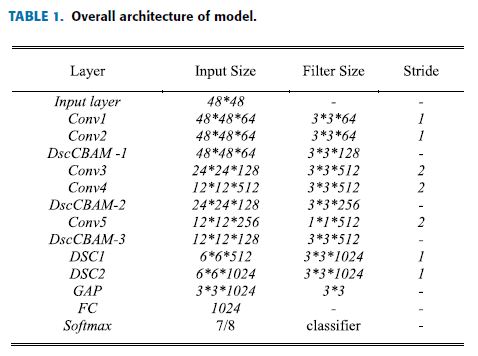

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             

 Total params: 19,895,815 (75.90 MB)

 Trainable params: 19,887,943 (75.87 MB)

 Non-trainable params: 7,872 (30.75 KB)

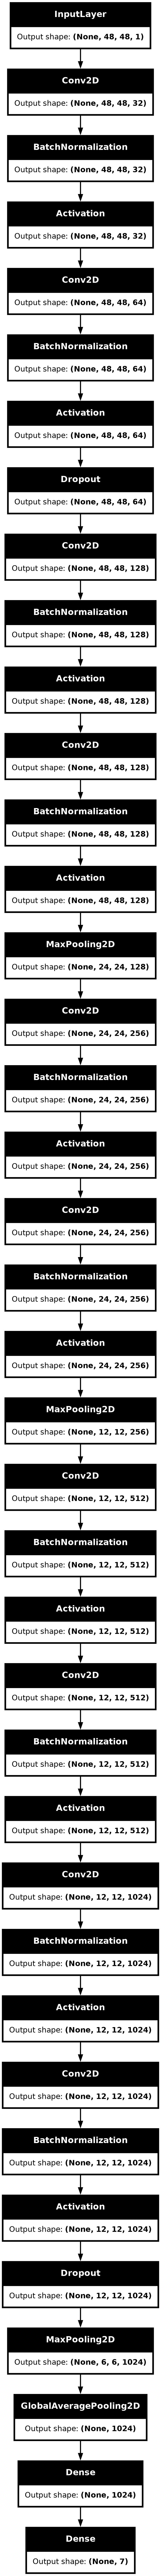

In [7]:
model = build_model()
model.summary()
plot_model(model, show_shapes = True)

# Meta Data

## Getting path and building CSV file

In [8]:
path = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge'
os.listdir(path)

df = pd.read_csv(path+'/icml_face_data.csv')
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Utility

In [9]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels and pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions(data, train_images, train_labels, emotions):
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(emotions, array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

## Dataframe Analysis

In [10]:
df[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

# Data preparation

## Dictionary to map class labels to names

In [11]:
label2name = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

## Making dictionary to map class names to class labels

In [12]:
name2label = {v: k for k, v in label2name.items()}
name2label

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Sad': 4,
 'Surprise': 5,
 'Neutral': 6}

## Adding class name column to dataframe

In [13]:
# transforming the labels to names

df['class_name'] = df['emotion'].map(label2name)
display(df.head(2))

,emotion,Usage,pixels,class_name
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Angry
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...,Angry


## Converting pixel value vector to greyscale image

In [14]:
train_image_array, train_image_labels = prepare_data(df[df[' Usage']=='Training'])
val_image_array, val_image_labels = prepare_data(df[df[' Usage']=='PublicTest'])
test_image_array, test_image_labels = prepare_data(df[df[' Usage']=='PrivateTest'])

# Data Validation

Before diving deeper into the analysis, it's crucial to ensure that our metadata – including path and label – aligns accurately with the actual data. Any discrepancies may lead to inaccurate results, undermining the integrity of our findings.

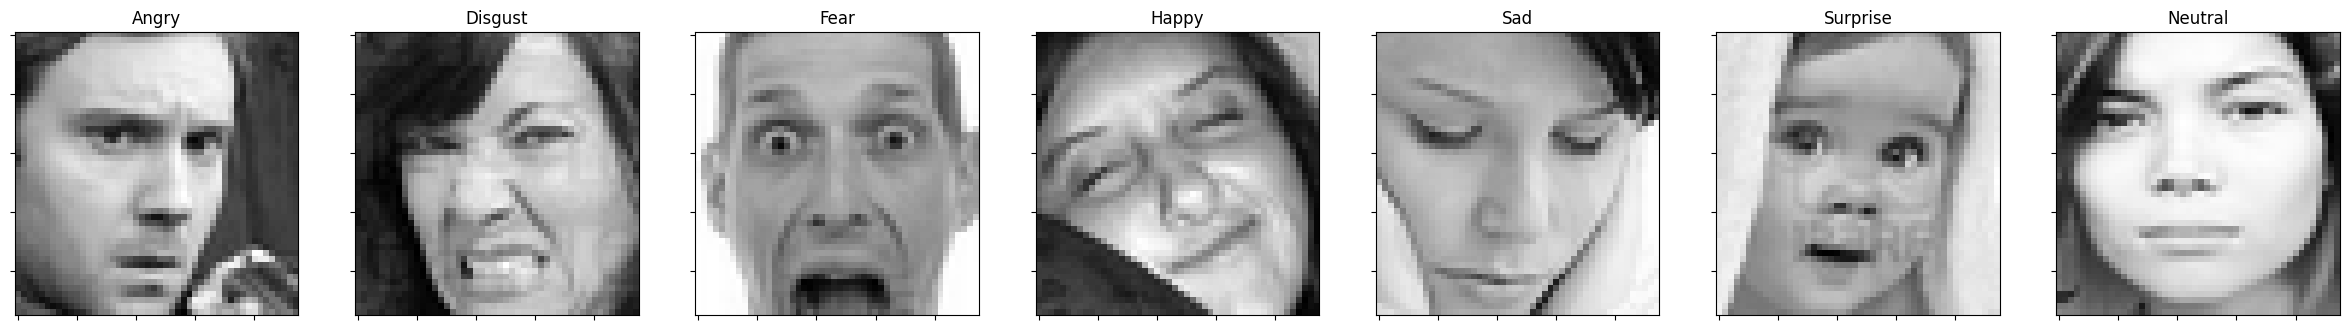

In [15]:
plot_all_emotions(df, train_image_array, to_categorical(train_image_labels), label2name)

## Class distribution

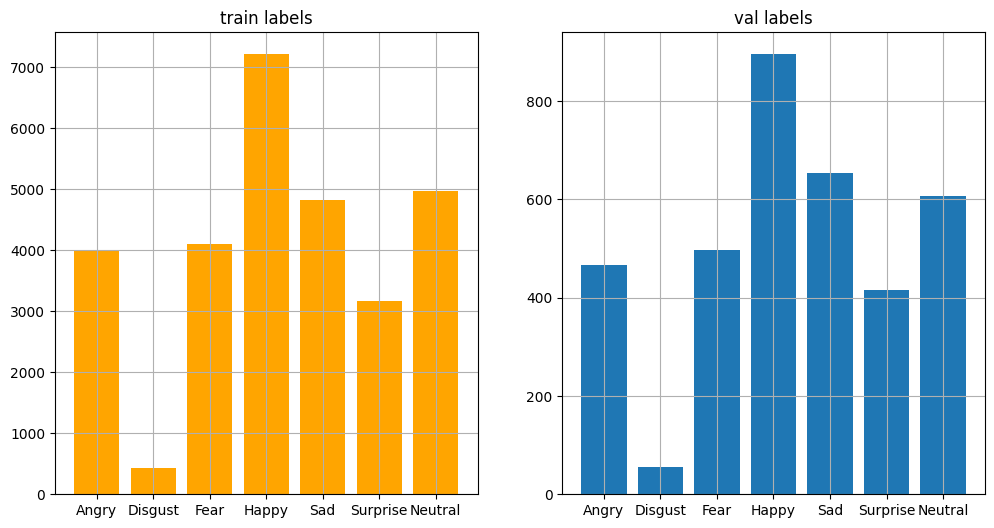

In [16]:
plot_compare_distributions(label2name, to_categorical(train_image_labels), to_categorical(val_image_labels), title1='train labels', title2='val labels')

# Class Weights for class distribution

To handle the imbalance in class distribution, class weights are used

In [17]:
class_weight = dict(zip(range(0, 7), (((df[df[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(df[df[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# DataLoader with  augmentation

In [18]:
"""
    Custom data loader for Keras model training.
    Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    Args:
        data (numpy.ndarray): Array of image data.
        labels (list): List of corresponding labels for the images. 
                       Set labels= None if you are infering on test dataset (where you dont have labels)
        batch_size (int): Number of samples per batch.
        num_classes (int): Number of classes in the dataset.
        dim (tuple): Dimensions of the input images.
        shuffle (bool): Whether to shuffle the data after each epoch.

    Methods:
        __len__(): Returns the number of batches per epoch.
        __getitem__(index): Generates one batch of data.
        on_epoch_end(): Updates indexes after each epoch.
        __data_generation(batch_indexes): Generates data for a batch.
    """
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, data, labels=None, batch_size=64, num_classes=7,
                 dim=(48, 48), shuffle=True, grayscale = False,
                 augment=False, augment_fn=None):
        """Initialization method for the DataLoader class."""
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dim = dim
        self.shuffle = shuffle
        self.grayscale = grayscale
        
        # For augmentation
        self.augment = augment
        self.augment_fn = augment_fn
        if self.augment and self.augment_fn is None:                   #set augmentations here
            self.augment_fn = A.Compose([A.HorizontalFlip(p=0.5),      # Horizontal flip with 50% probability
                                         A.VerticalFlip(p=0.5),        # Vertical flip with 50% probability
                                         A.RandomScale(p=0.5),         # Random zoom transformation with 50% probability
                                         A.Rotate(limit=30, p=0.5),    # Random rotation transformation with 50% probability
                                         #A.RandomSizedCrop(min_max_height=(200, 200), height=200, width=200, p=0.5), # Random crop and resize
                                         A.Affine(shear=(-30, 30), p=0.5),  # Shear transformation with a range of -10 to 10 degrees
                                         A.Resize(width=48, height=48),  # Resize the image to a fixed size
                                         A.PadIfNeeded(min_height=48, min_width=48, border_mode=0),  # Add padding if needed to maintain size
                                        ])
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        batch = self.__data_generation(batch_indexes)

        return batch

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """Generates data containing batch_size samples."""
        # Grayscale checked X initialization 
        if self.grayscale == True:
            X = np.empty((self.batch_size, *self.dim))     #if grayscale, no channels
        else:
            X = np.empty((self.batch_size, *self.dim, 3))  #if not grayscale, RGB
            
        # Initialization
        if self.labels is not None:
            y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Load sample
            img = self.data[idx]
            
            # Apply augmentation
            if self.augment:
                img = self.augment_fn(image=img)["image"]
                
            # Store Sample
            X[i,] = img

            # Store class
            if self.labels is not None:
                y[i] = self.labels[idx]

        # Flatten the image pixels for Dense layer
#         X = X.reshape(self.batch_size, -1)  # shape: (32, 28, 28) => (32, 28*28) => (32, 784)

        # Do scaling, range: [0, 255] => [0, 1]
        X = X / 255.0

        # Apply one-hot encoding to labels [0, 1, 2] => [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        if self.labels is not None:
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            return X, y
        
        # if there is labels = None, then only return X
        return X

## Loader check

In [19]:
#paths = train_df.image_path.tolist()
#labels = train_df.class_label.tolist()

train_loader = DataLoader(train_image_array, train_image_labels, batch_size=16, grayscale = True)

imgs, tars = train_loader.__getitem__(0)
print("Images:\n", imgs.shape)

print("\nLabels:\n", tars.shape)

Images:
 (16, 48, 48)

Labels:
 (16, 7)


In [20]:
imgs.shape, tars.shape

((16, 48, 48), (16, 7))

## Visualize Loader

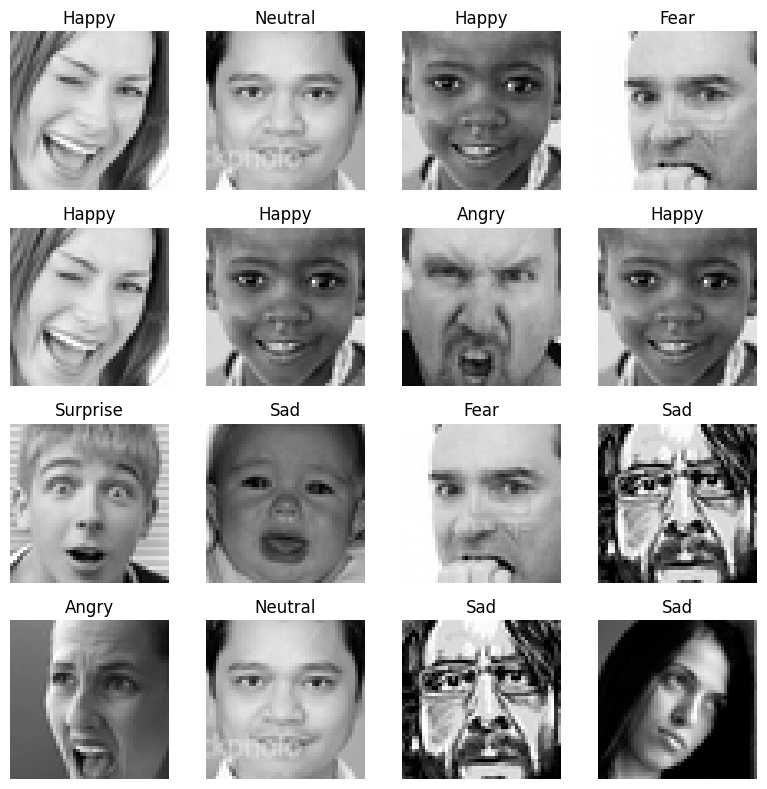

In [21]:
# Define the size of the grid
grid_size = 4

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(16):
    # Generate random index
    img_idx = np.random.randint(0, 16)
    
    # Load the image
    img = imgs[img_idx].reshape(48, 48, 1) # images are feed as flatten to models
    
    # Get Label
    tar = tars[img_idx].argmax(axis=-1) # label is one hot encoded
    name = label2name[tar]

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img, cmap = 'gray')
    axes[x, y].set_title(name)
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

# Model Training and Compilation

In [22]:
# Step 1: Get train-test image paths and labels

#Training data: train_image_array, train_image_labels
#Validation data: val_image_array, val_image_labels
#Test data: test_image_array, test_image_labels

# Step 2: Data loader
train_loader = DataLoader(train_image_array, train_image_labels, batch_size=BATCH_SIZE, grayscale = True, augment = True)  #set augment=True for augmentations, remove for no augmentations

valid_loader = DataLoader(val_image_array, val_image_labels, batch_size=VALID_BATCH_SIZE, shuffle=False, grayscale = True, augment = False)


# Step 3: Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Step 4: Model training
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/best_aug_ckpt.keras',
                                             monitor = 'val_accuracy',
                                             verbose = 0,
                                             save_best_only = True,
                                             save_weights_only = False,
                                             mode = 'max') # to save best scoring model

#Reducing learning rate if validation loss does not decrease
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

# Implementing Early Stopping if validation loss starts increasing 
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=EARLY_STOPPING_PATIENCE, verbose=2) 

#Training start
print('## Training')
history = model.fit(train_loader,
                    validation_data=valid_loader,
                    class_weight=class_weight,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[reduce_lr, early_stopping, ckpt_cb])

# Step 5: Predict on test data

## Load best model
model = tf.keras.models.load_model('/kaggle/working/best_aug_ckpt.keras', safe_mode=False) # you can save model using model.save()
model.save('./bestmodel.keras')

print("\n## Inference")
test_loader = DataLoader(test_image_array, labels=None, batch_size=BATCH_SIZE, shuffle=False, grayscale = True)
predictions = model.predict(test_loader)

# Step 6: Measure performance
acc = accuracy_score(test_image_labels, predictions.argmax(-1))
print(f"\n## Accuracy: {acc}")

## Training
Epoch 1/300


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-01 16:37:22.555505: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.16473, expected 0.928603
2024-03-01 16:37:22.555561: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 1.1794, expected 0.943274
2024-03-01 16:37:22.555588: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 0.892153, expected 0.656024
2024-03-01 16:37:22.555601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 1.163, expected 0.926874
2024-03-01 16:37:22.555612: E external/local_xla/xla/service/gpu/buffer_comparator.cc

  1/449 ━━━━━━━━━━━━━━━━━━━━ 4:27:24 36s/step - accuracy: 0.2188 - loss: 0.4324

I0000 00:00:1709311068.325142     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/449 ━━━━━━━━━━━━━━━━━━━━ 91s 123ms/step - accuracy: 0.2423 - loss: 0.3333 - val_accuracy: 0.2490 - val_loss: 2.1626 - learning_rate: 0.0010
Epoch 2/300
449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.2555 - loss: 0.2860 - val_accuracy: 0.2616 - val_loss: 1.7921 - learning_rate: 0.0010
Epoch 3/300
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.2564 - loss: 0.2810 - val_accuracy: 0.2599 - val_loss: 1.7902 - learning_rate: 0.0010
Epoch 4/300
449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.2862 - loss: 0.2713 - val_accuracy: 0.3393 - val_loss: 1.6889 - learning_rate: 0.0010
Epoch 5/300
449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.3488 - loss: 0.2539 - val_accuracy: 0.3855 - val_loss: 1.5876 - learning_rate: 0.0010
Epoch 6/300
449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.3912 - loss: 0.2386 - val_accuracy: 0.3911 - val_loss: 1.5957 - learning_rate: 0.0010
Epoch 7/300
449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.4204 -

ValueError: Found input variables with inconsistent numbers of samples: [3589, 3648]

## Plot History

In [ ]:
def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], '-o')
    plt.plot(history.history['val_accuracy'], '-o')
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation accuracy is max
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc)
    plt.annotate(f'best: {best_val_acc:.2f} @ {best_val_acc_epoch+1}',
                 xy=(best_val_acc_epoch, best_val_acc),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], '-o')
    plt.plot(history.history['val_loss'], '-o')
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation loss is min
    best_val_loss_epoch = best_val_acc_epoch
    best_val_loss = history.history['val_loss'][best_val_loss_epoch]
    plt.annotate(f'best: {best_val_loss:.2f} @ {best_val_loss_epoch+1}',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    plt.tight_layout()
    plt.show()
    
# Plot history of training
plot_history(history)

## Result Analysis

In [ ]:
num_images = 36
sqrt_num_images = int(np.sqrt(num_images))
indices = np.random.choice(len(test_image_array), num_images, replace=False)
fig, axes = plt.subplots(nrows=sqrt_num_images, ncols=sqrt_num_images, figsize=(10, 10))

for i, idx in enumerate(indices):
    row = i // sqrt_num_images
    col = i % sqrt_num_images

    image = test_image_array[idx]
    #image = load_image(image_path)  # Load and preprocess single image
    
    # Get prediction and ground truth
    pred = np.argmax(predictions[idx], axis=-1)
    pred = label2name[pred] # converting labels to names
    true = valid_labels[idx]
    true = label2name[true] # converting labels to names

    axes[row, col].imshow(image, cmap = 'gray')
    axes[row, col].axis('off')

    if pred == true:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}')
    else:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}', color='red')

plt.tight_layout()
plt.show()